**Connect Colab with Google Drive**

# **Detectron2: PyTorch 기반 모듈식 객체 감지 라이브러리**
Detectron2는 Facebook 에서 만든 딥러닝 기반의 객체 탐지 및 분할 라이브러리입니다.  

**1. Detectron2 설치**  
- Google Colab 환경에서 Detectron2를 설치하고 설정합니다
- 설치에 5 분 정도 소요

**2. COCO 데이터셋 및 사전 학습된 모델 로드**

**3. 사전 학습된 Faster R-CNN 모델로 객체 탐지**

**4. 사전 학습된 Mask R-CNN을 이용한 객체 분할**

**5. 사용자 정의 데이터셋(Balloon Dataset) 미세 조정(Fine-tuning)**

**6. Detectron2를 사용한 모델 학습 (Fine-Tuning)**

**7. 학습된 모델을 사용한 추론 및 평가**

In [1]:
# # PyYAML 5.3 버전 설치 (Detectron2에서 요구하는 버전)
# # Detectron2 최신 버전을 GitHub에서 설치 (facebookresearch 공식 저장소)
# !python3 -m pip install pyyaml==5.3
# !python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

필요한 라이브러리 임포트

In [2]:
import detectron2

# Detectron2의 로거(Logger)를 설정하는 코드
# 로거(Logger)는 모델 실행 중 발생하는 정보(예: 학습 상태, 경고 메시지, 오류 등)를 기록하고 출력합니다.
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
#https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

# Detectron2에서 제공하는 사전 학습된 모델(예: Faster R-CNN, Mask R-CNN)
from detectron2 import model_zoo

# 사전 학습된 모델을 사용해 이미지에서 추론(예측)을 수행하는 API
from detectron2.engine import DefaultPredictor 

# Detectron2 모델 설정(configuration) 관리
from detectron2.config import get_cfg

# 객체 탐지 및 분할 결과를 시각화(예: 이미지 위에 바운딩 박스, 마스크, 클래스 정보 추가)
from detectron2.utils.visualizer import Visualizer

# 데이터셋의 메타데이터(예: 클래스 이름, 색상 등)를 관리
from detectron2.data import MetadataCatalog, DatasetCatalog

import numpy as np
import torch, os, json, cv2, random
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# https://cocodataset.org/#home

# COCO 2017 train 데이터셋의 메타데이터를 불러옵니다.
metadata = MetadataCatalog.get('coco_2017_train')

# 메타데이터에서 클래스 이름(thing_classes)을 가져옵니다.
class_names = metadata.get('thing_classes')

# 클래스의 개수와 이름을 출력합니다.
print("COCO 데이터셋 클래스 개수:", len(class_names))
print("COCO 데이터셋 클래스 이름:", class_names)

COCO 데이터셋 클래스 개수: 80
COCO 데이터셋 클래스 이름: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


- Local PC 에서 aeroplane image 찾아서 upload

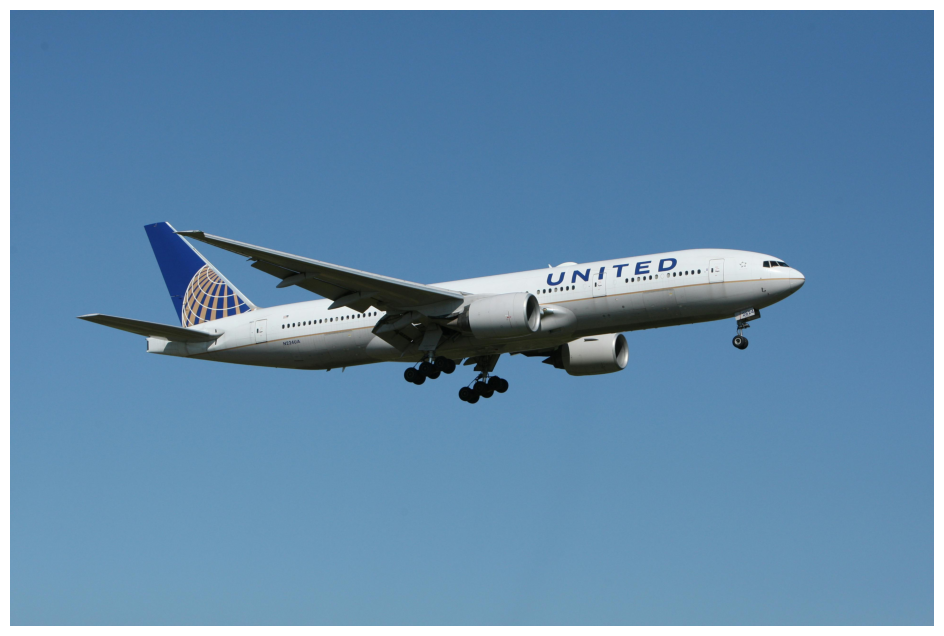

In [4]:
import os
data_path = '../Datasets/images'
aeroplane = cv2.imread(os.path.join(data_path, 'aeroplane.jpg'))
aeroplane_RGB = cv2.cvtColor(aeroplane, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 8))
plt.imshow(aeroplane_RGB)
plt.axis('off')
plt.show()

## 사전 학습된 Detectron2 모델을 사용한 객체 감지




### Faster R-CNN
- `faster_rcnn_R_101_FPN_3x`  사전학습 모델 사용
```
- R_101 : ResNet 101 Layer   
- FPN :  Feature Pyramid Network - 객체 탐지에서 다양한 크기의 객체를 효과적으로 탐지하기 위해 사용되는 구조  
- 3x: 기본 학습 스케줄의 3배(270,000 iteration, 약 36 epoch)
```

In [5]:
# Detectron2에서 COCO 데이터셋 기반 사전 학습된 객체 탐지 모델 설정
# 참조: https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-Detection

# Detectron2의 모델 설정 객체(cfg) 생성
cfg = get_cfg()

# 사전 학습된 Faster R-CNN 모델 구성 불러오기
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))

#  Faster R-CNN 모델의 사전 학습된 가중치 불러오기
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml')

# 객체를 탐지할 최소 신뢰도(점수) 임계값을 0.5로 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

cfg.MODEL.DEVICE = device

# predictor 생성
predictor = DefaultPredictor(cfg)

[09/22 21:49:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


In [6]:
predictor

In [7]:
# 사전 학습된 Faster R-CNN 모델(R_101_FPN_3x)을 사용하여 객체 탐지 수행
outputs = predictor(aeroplane)

vars(outputs['instances'])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'_image_size': (2592, 3888),
 '_fields': {'pred_boxes': Boxes(tensor([[ 272.1062,  909.1255, 3313.0547, 1631.7375]], device='mps:0')),
  'scores': tensor([0.9990], device='mps:0'),
  'pred_classes': tensor([4], device='mps:0')}}

```
{
    '_image_size': (2592, 3888),  # 입력 이미지의 크기
    '_fields': {
        'pred_boxes': Boxes(tensor([...]))  # 예측된 바운딩 박스 좌표 (x1,y1,x2,y2)
        'scores': tensor([...])  # 각 객체의 신뢰도 점수
        'pred_classes': tensor([...])  # 각 객체의 클래스
    }
}

```

In [8]:
# 출력 확인. 모델 출력 형식에 대한 자세한 내용은 [Detectron2 공식 문서](https://detectron2.readthedocs.io/tutorials/models.html#model-output-format) 참조
print(outputs['instances'].pred_classes)
print(outputs['instances'].pred_boxes)

tensor([4], device='mps:0')
Boxes(tensor([[ 272.1062,  909.1255, 3313.0547, 1631.7375]], device='mps:0'))


In [9]:
def img_imshow(img):
    plt.figure(figsize=(14, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

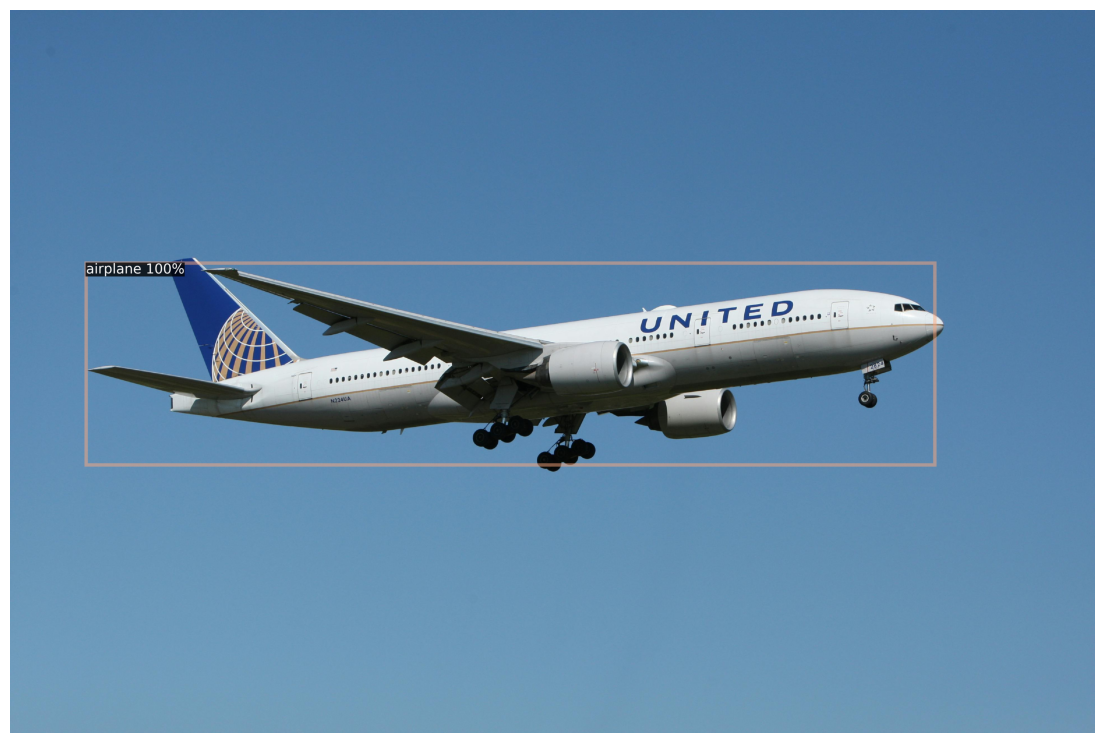

In [10]:
# Detectron2의 Visualizer를 사용하여 이미지 시각화

v = Visualizer(
    aeroplane[:, :, ::-1], # BGR -> RGB
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), # 훈련 데이터셋의 메타데이터를 가져와서 시각화
    scale=1.2
)


# 예측 결과(outputs["instances"])를 CPU로 변환한 뒤, Visualizer를 사용해 바운딩 박스, 마스크 등을 시각화
v = v.draw_instance_predictions(outputs['instances'].to('cpu'))

# Matplotlib을 사용해 결과를 화면에 출력
img_imshow(v.get_image())

In [11]:
# 예측된 클래스 레이블을 리스트로 변환
predicted_classes = outputs['instances'].pred_classes.tolist()

# # 클래스 ID를 클래스 이름으로 변환
predicted_class_names = [class_names[class_id] for class_id in predicted_classes]

# 예측된 클래스 이름을 출력합니다.
print('예측된 클래스 이름 ', predicted_class_names)

# 예측된 바운딩 박스 좌표를 출력합니다.
print('예측된 바운딩 박스 ', outputs['instances'].pred_boxes)

예측된 클래스 이름  ['airplane']
예측된 바운딩 박스  Boxes(tensor([[ 272.1062,  909.1255, 3313.0547, 1631.7375]], device='mps:0'))


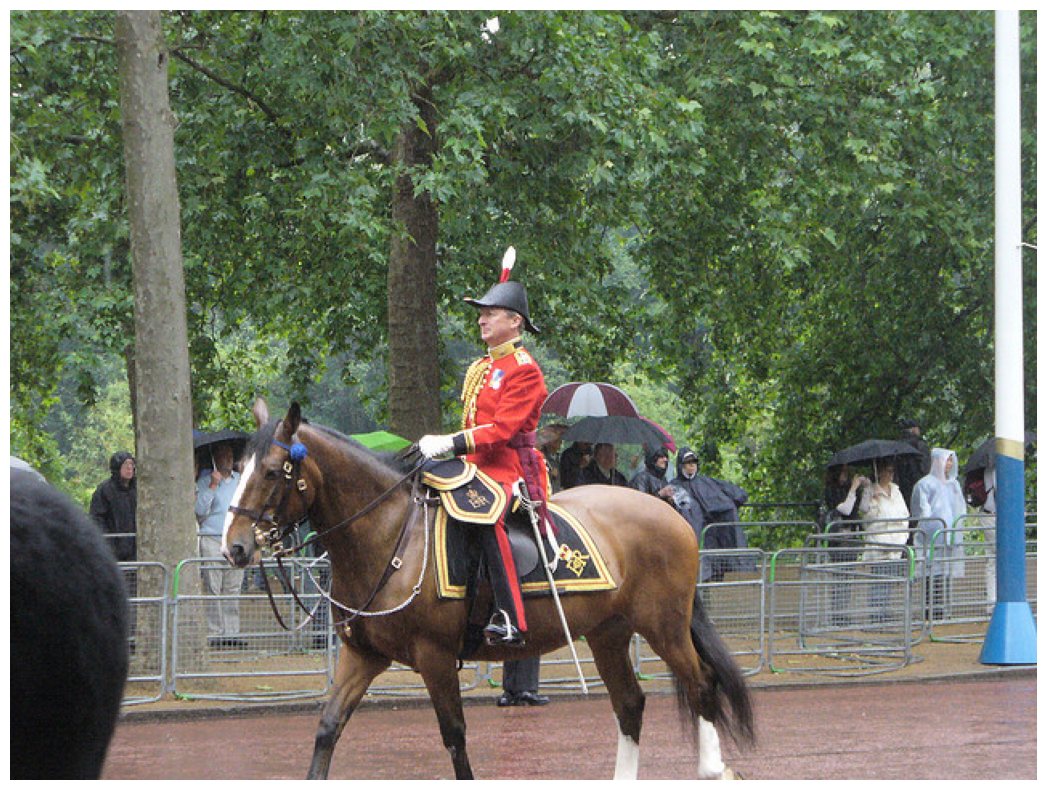

In [12]:
# COCO 데이터셋의 이미지 중 한개를 다운로드 (-q : 진행상황 표시 X, -O: 파일 이름 지정)
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg

# OpenCV를 사용하여 다운로드한 이미지를 읽어 NumPy 배열 형식으로 메모리에 로드
coco_image = cv2.imread('./input.jpg')
coco_image_rgb = cv2.cvtColor(coco_image, cv2.COLOR_BGR2RGB)

img_imshow(coco_image_rgb)

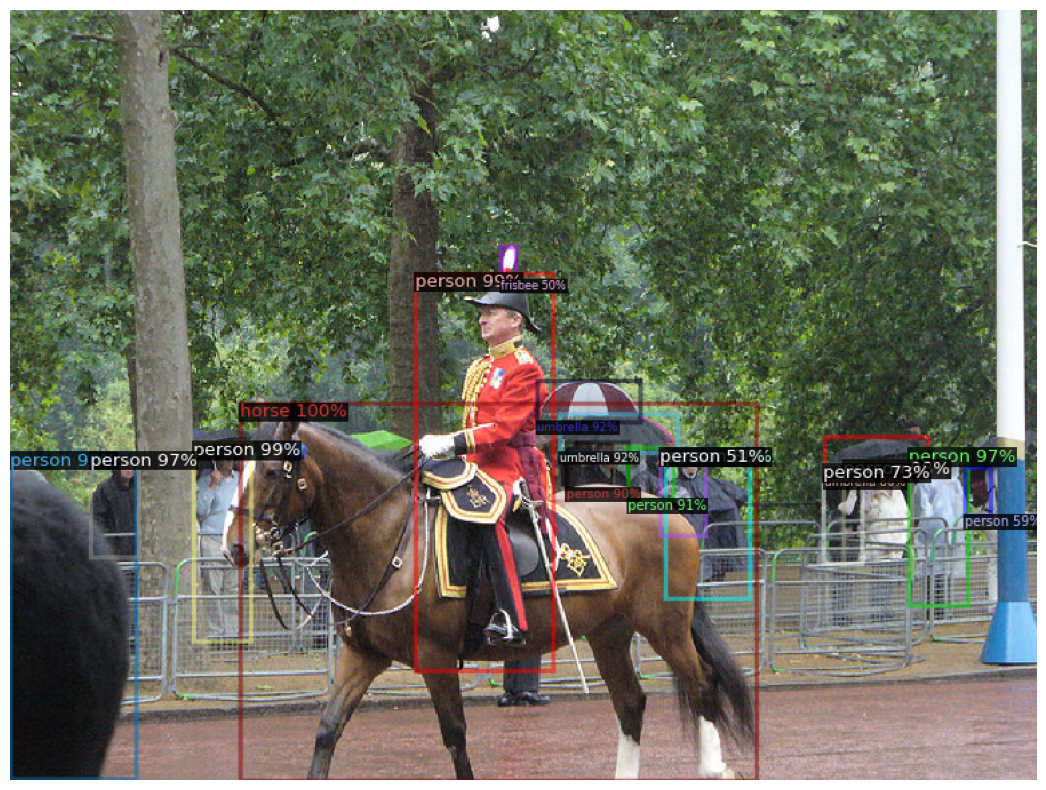

예측된 클래스 이름 ['horse', 'person', 'person', 'person', 'person', 'person', 'person', 'umbrella', 'umbrella', 'person', 'person', 'person', 'umbrella', 'person', 'person', 'person', 'frisbee']
예측된 바운딩 박스 Boxes(tensor([[1.4324e+02, 2.4539e+02, 4.6495e+02, 4.7987e+02],
        [1.1441e+02, 2.6908e+02, 1.4962e+02, 3.9316e+02],
        [2.5247e+02, 1.6397e+02, 3.3820e+02, 4.1206e+02],
        [1.0697e-01, 2.7545e+02, 7.8442e+01, 4.7884e+02],
        [5.1929e+02, 2.8065e+02, 5.6126e+02, 3.4840e+02],
        [5.6006e+02, 2.7298e+02, 5.9637e+02, 3.7065e+02],
        [4.9831e+01, 2.7545e+02, 7.9595e+01, 3.4123e+02],
        [3.4256e+02, 2.5185e+02, 4.1623e+02, 2.7543e+02],
        [3.2863e+02, 2.3107e+02, 3.9233e+02, 2.5647e+02],
        [3.8529e+02, 2.7219e+02, 4.1352e+02, 3.0471e+02],
        [3.4631e+02, 2.6899e+02, 3.8501e+02, 2.9849e+02],
        [4.0797e+02, 2.7319e+02, 4.6071e+02, 3.6698e+02],
        [5.0778e+02, 2.6580e+02, 5.7188e+02, 2.9060e+02],
        [5.0673e+02, 2.8314e+02, 5.3047e+

In [13]:
# 사전 학습된 Faster R-CNN 모델(R_101_FPN_3x)을 사용하여 객체 탐지 수행
outputs = predictor(coco_image)

# Detectron2의 Visualizer를 사용하여 이미지를 시각화
v = Visualizer(
    coco_image[:, :, ::-1],
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
    scale=1.2
)

v = v.draw_instance_predictions(outputs['instances'].to('cpu'))

img_imshow(v.get_image())

predicted_classes = outputs['instances'].pred_classes.tolist()
predicted_class_names = [class_names[class_id] for class_id in predicted_classes]
print('예측된 클래스 이름', predicted_class_names)
print('예측된 바운딩 박스', outputs['instances'].pred_boxes)

### Mask R-CNN을 이용한 객체 분할

- Mask R-CNN (mask_rcnn_R_50_FPN_3x)을 사용  
- 물체 탐지(Object Detection) + 인스턴스 분할(Instance Segmentation)

In [27]:
# Detectron2의 설정 객체 생성
cfg = get_cfg()

# COCO 데이터셋에서 학습된 ResNet-50 백본 Mask R-CNN 모델 구성 파일 불러오기
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# 객체 검출 시 사용할 점수 임계값(Threshold) 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Detectron2 모델 저장소(Model Zoo)에서 사전 학습된 모델의 가중치 불러오기
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

# 실행할 디바이스 설정 (cuda, mps, cpu 중 자동 선택)
cfg.MODEL.DEVICE = device

# DefaultPredictor 객체 생성
predictor = DefaultPredictor(cfg)

[09/22 23:03:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [30]:
outputs = predictor(coco_image)

print(coco_image.shape)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_masks.shape) # 검출된 객체들에 대한 픽셀들 0, 1

(480, 640, 3)
tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='mps:0')
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3743, 562.2792, 389.3803],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7348, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='mps:0'))
torch.Size([15, 480, 640])


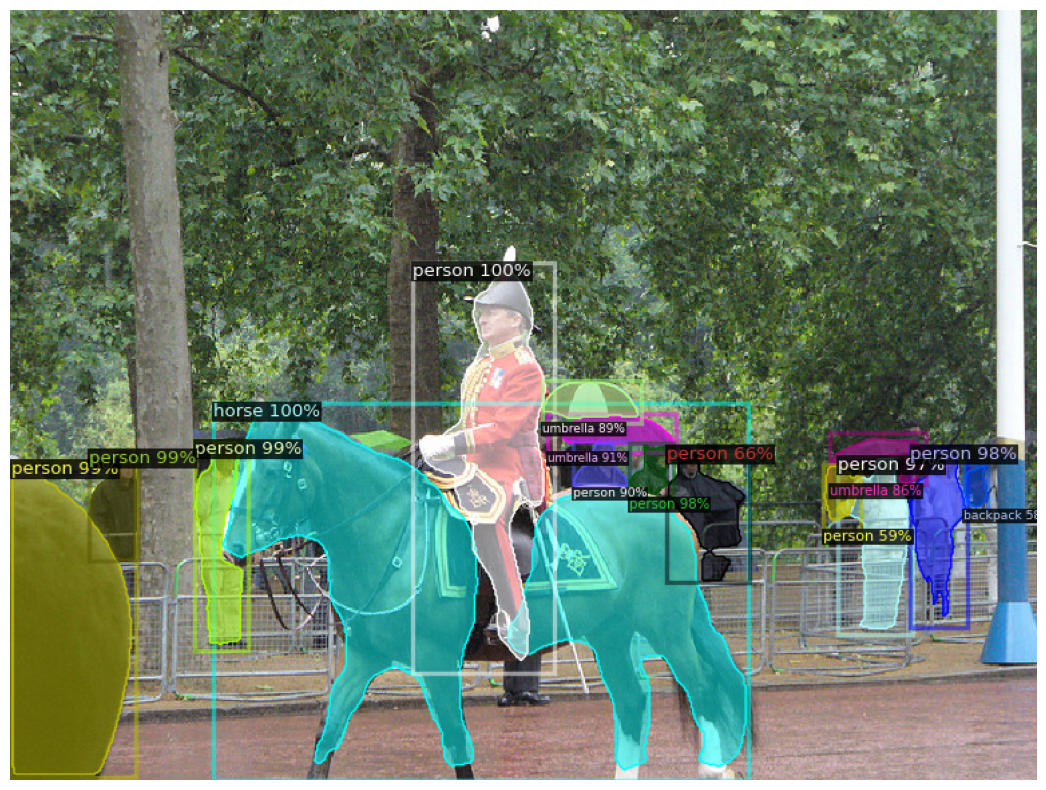

In [35]:
# `Visualizer`를 사용하여 이미지에 예측 결과를 그립니다.
v = Visualizer(coco_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
img_imshow(v.get_image())

## 사용자 정의 데이터셋(Balloon Dataset) 미세 조정(Fine-tuning)

COCO dataset 에는 baloon category 가 없으므로 COCO dataset으로 사전 학습된 Mask R-CNN 모델은 baloon 을 detect 하지 못함

In [ ]:
# Local PC 에서 baloons.jpg upload
# 사전 학습된 Mask R-CNN 으로 예측

In [ ]:
# Detectron2의 Visualizer를 사용하여 이미지를 시각화
# 예측 결과(outputs["instances"])를 CPU로 변환한 뒤, Visualizer를 사용해 바운딩 박스, 마스크 등을 시각화
# Matplotlib을 사용해 결과를 화면에 출력

## 사용자 정의 데이터세트에서 학습 (Fine Tuning)
새 형식의 사용자 정의 데이터세트에서 기존 detectron2 모델을 학습하는 방법.

풍선이라는 클래스가 하나뿐인 baloon segmentation dataset을 사용합니다. detectron2의 model zoo에서 제공되는 COCO 데이터세트에서 사전 학습된 기존 모델에서 baloon segmentation 모델을 학습합니다.

COCO 데이터세트에는 "baloon" category가 없습니다. 몇 분 안에 이 새로운 클래스를 인식할 수 있을 것입니다.

In [ ]:
# 풍선(Balloon) 데이터셋 압축 파일 다운로드 (Matterport의 Mask R-CNN 예제용 데이터셋)
# 다운로드한 압축 파일을 현재 디렉토리에 해제 (출력은 생략)

# JSON 파일 변환 (VIA 형식 --> COCO 형식)
- baloon_dataset은 VIA 형식의 JSON 파일이므로 COCO 형식으로 변환 필요   
- VIA (VGG Image Annotator) 형식   
```
{
  "fileref": "",  // 파일 참조 (보통 빈 문자열로 유지됨)
  "size": 668058,  // 이미지 파일 크기 (바이트 단위)
  "filename": "24631331976_defa3bb61f_k.jpg",  // 이미지 파일 이름
  "base64_img_data": "",  // Base64 인코딩된 이미지 데이터 (현재 없음)
  "file_attributes": {},  // 이미지에 대한 추가 속성 (현재 없음)
  "regions": {  // 이미지에서 객체(관심 영역, ROI)를 정의하는 부분
    "0": {  // 첫 번째 객체 (여러 개의 영역이 있을 경우 "1", "2", ... 로 증가)
      "shape_attributes": {  // 해당 영역의 도형(Shape) 속성
        "name": "polygon",  // 다각형(Polygon) 형태의 영역
        "all_points_x": [916, 913, 905, ...],  // 다각형 꼭짓점의 X 좌표 리스트
        "all_points_y": [515, 583, 616, ...]  // 다각형 꼭짓점의 Y 좌표 리스트
      },
      "region_attributes": {}  // 특정 객체(영역)의 속성 (현재 없음)
    }
  }
}
```

- COCO 형식의 JSON 파일
```
{
  "info": {  // 데이터셋 정보
    "description": "Custom Dataset",  // 데이터셋 설명
    "version": "1.0",  // 버전 정보
    "year": 2025,  // 데이터셋 생성 연도
    "contributor": "User",  // 기여자 정보
    "date_created": "2025-03-05"  // 데이터셋 생성 날짜
  },
  "licenses": [  // 라이선스 정보
    {
      "id": 1,  
      "name": "Attribution 4.0 International (CC BY 4.0)",  // 라이선스 이름
      "url": "https://creativecommons.org/licenses/by/4.0/"  // 라이선스 URL
    }
  ],
  "images": [  // 이미지 정보 목록
    {
      "id": 1,  // 이미지 ID (고유 식별자)
      "file_name": "24631331976_defa3bb61f_k.jpg",  // 이미지 파일명
      "width": 1024,  // 이미지 너비
      "height": 768,  // 이미지 높이
      "license": 1,  // 사용된 라이선스 ID
      "date_captured": "2025-03-05"  // 이미지 캡처 날짜
    }
  ],
  "annotations": [  // 주석(Annotation) 정보 목록
    {
      "id": 1,  // 객체 ID (고유 식별자)
      "image_id": 1,  // 해당 객체가 속한 이미지 ID
      "category_id": 1,  // 객체의 카테고리 ID (categories에서 정의됨)
      "segmentation": [  // 다각형(Polygon) 형태의 객체 경계선 좌표[x1, y1, x2, y2, ..xn, yn]
        [916, 515, 913, 583, 905, 616, 889, 656, 868, 696, 836, 737,
         809, 753, 792, 767, 789, 777, 784, 785, 777, 785, 769, 778,
         767, 768, 777, 766, 786, 760, 791, 755, 769, 755, 739, 743,
         714, 728, 678, 702, 645, 670, 615, 629, 595, 588, 583, 539,
         580, 500, 584, 458, 595, 425, 614, 394, 645, 360, 676, 342,
         716, 329, 769, 331, 815, 347, 849, 371, 875, 398, 900, 442,
         916, 504]
      ],
      "area": 50000,  // 객체의 영역(면적), 단위: 픽셀^2
      "bbox": [580, 329, 336, 456],  // 바운딩 박스 좌표 (xmin, ymin, width, height)
      "iscrowd": 0  // 객체가 개별적인지 여부 (0: 개별 객체, 1: 군집 객체)
    }
  ],
  "categories": [  // 객체(카테고리) 정보 목록
    {
      "id": 1,  // 카테고리 ID (annotations의 category_id와 연결됨)
      "name": "object",  // 객체 이름 (예: "balloon", "car" 등)
      "supercategory": "none"  // 상위 카테고리 (없으면 "none")
    }
  ]
}
```

In [ ]:
# JSON 파일 경로에서 'via_region_data.json'을 열고, UTF-8로 인코딩하여 읽어옴
# 파싱된 annotation 데이터에서 첫 번째 항목만 출력

In [ ]:
# JSON 데이터 출력
    # 이미지 ID 출력 (예: '100001.jpg12345')
    # 파일 이름과 크기 출력 (없을 경우 'N/A'로 표시)
    # 해당 이미지에 포함된 객체(Region) 정보 출력
        # 객체의 도형 정보(다각형 등)
        # 객체의 분류 등 기타 속성
# 전체 이미지(annotation) 개수 출력

In [ ]:
# 데이터 세트가 COCO 형식인 경우 이 셀은 다음 세 줄로 대체될 수 있습니다.:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
# Detectron2의 BoxMode 모듈 가져오기 (바운딩 박스 모드 지정)
# VIA 형식의 Annotation을 COCO 형식으로 변환하여 Detectron2에서 사용할 수 있는 딕셔너리 생성
def get_balloon_dicts(img_dir):
    # 이미지 디렉터리에서 JSON 파일 경로 지정
        # 이미지 파일 경로와 크기 정보 저장
        # 이미지 메타데이터 설정
        # 이미지의 주석(객체 정보) 처리
            # 객체 정보를 딕셔너리에 저장
# 학습(train) 및 검증(val) 데이터셋 등록
    # 데이터셋을 Detectron2에 등록
    # 데이터셋의 메타데이터 설정
# 학습 데이터셋의 메타데이터 가져오기

데이터 세트가 올바른 형식인지 확인하기 위해 학습 세트에서 무작위로 선택한 샘플의 주석을 시각화해 보겠습니다.

In [ ]:
# 학습 데이터셋에서 3개의 샘플을 무작위로 선택하여 시각화
# "balloon/train" 경로의 데이터셋을 Detectron2 형식으로 변환하여 가져오기
# 데이터셋에서 무작위로 3개의 샘플을 선택
    # 이미지 파일을 읽어오기 (cv2.imread는 이미지를 BGR 형식으로 읽음)
    # Detectron2의 Visualizer를 사용하여 이미지 시각화
    # 데이터셋 정보(d)를 사용해 바운딩 박스, 세그멘테이션 등을 이미지 위에 그리기
    # 시각화 결과를 Colab 환경에서 표시 (cv2_imshow는 Colab에서 사용)

## Train

이제 COCO 사전 훈련된 R50-FPN 마스크 R-CNN 모델을 풍선 데이터 세트에서 미세 조정해 보겠습니다. P100 GPU에서 300회 반복을 훈련하는 데 약 2분이 걸립니다.

In [ ]:
# Detectron2에서 데이터 로딩 속도 최적화

In [ ]:
# 실행 시작 시간 기록
# Detectron2의 기본 학습 트레이너(DefaultTrainer)를 불러옵니다.
# Detectron2의 설정 객체 생성
# 사전 학습된 Mask R-CNN 모델 구성 파일 로드
# 학습 데이터셋 설정 ("balloon_train"으로 등록된 데이터셋 사용)
# DataLoader의 워커 수 설정 (데이터 로드 병렬 처리, 워커 수는 CPU 코어 수와 관련)
# 사전 학습된 모델 가중치 설정 (Detectron2 Model Zoo에서 가져옴)
# 배치 크기 설정 (1번 학습 단계에서 처리할 이미지 수)
# 학습률(Learning Rate) 설정
# 학습 반복(iteration) 수 설정
# 학습률 감소 단계 설정
# RoI(Region of Interest) Head의 배치 크기 설정. 각 이미지에서 128개의 RoI sample을 학습에 사용
# 모델의 클래스 수 설정
# 출력 디렉터리 생성 (학습 결과 저장 디렉터리)
# 기본 학습 트레이너(DefaultTrainer) 생성

In [ ]:
# 실행 종료 시간 기록
# 실행 시간 출력

## 훈련된 모델을 사용한 추론 및 평가
이제 훈련된 모델로 baloon validation 데이터 세트에 대해  추론을 실행해 보겠습니다. 먼저 방금 훈련한 모델을 사용하여 predictor를 만들어 보겠습니다.

In [ ]:
# cfg 객체는 학습 시 사용했던 설정을 그대로 포함하고 있으며, 추론에 필요한 몇 가지 설정을 추가로 변경합니다.
# 방금 학습한 모델의 최종 가중치 경로 설정
# 추론 시 신뢰도 임계값 설정 (0.7 이상인 경우에만 예측 결과를 출력)
# DefaultPredictor 생성

여러 샘플을 무작위로 선택하여 예측 결과를 시각화 합니다.

In [ ]:
# 검증 데이터셋("balloon/val")을 Detectron2 형식으로 가져옴
# 검증 데이터셋에서 무작위로 3개의 샘플을 선택
    # 이미지 파일 읽기 (OpenCV는 기본적으로 BGR 형식으로 이미지를 읽음)
    # 학습된 모델을 사용하여 이미지에서 객체 추론
    # Visualizer를 사용하여 추론 결과를 시각화
    # 모델 추론 결과(outputs["instances"])를 시각화
    # Colab 환경에서 이미지를 표시 (cv2_imshow는 이미지를 BGR 형식으로 표시)

In [ ]:
# 학습된 모델을 사용하여 이미지에서 객체 추론
# 예측

In [ ]:
# 학습된 모델을 사용하여 이미지에서 객체 추론
# Visualizer를 사용하여 추론 결과를 시각화
# 모델 추론 결과(outputs["instances"])를 시각화
# Colab 환경에서 이미지를 표시 (cv2_imshow는 이미지를 BGR 형식으로 표시)